all vocabularies sorted from more frequent to less frequent:
 ['9' '3' 'o' '6' 'a' '1' 'i' 'g' 's' '4' 'l' 'k' '8' 'u' '2' 'd' '5' 'y'
 'f' 'e' 'h' 'p' 'q' '0' 'j' '7' 't' 'r' 'w' 'n']
5 example pairs:
 [[16 14]
 [16  9]
 [14 16]
 [14  9]
 [14 12]]
9
3
o
0
2
step: 0 | loss: 8.620213508605957
step: 200 | loss: 3.9101638793945312
step: 400 | loss: 2.7952260971069336
step: 600 | loss: 2.3444466590881348
step: 800 | loss: 2.5884666442871094
step: 1000 | loss: 2.303880453109741
step: 1200 | loss: 2.3289074897766113
step: 1400 | loss: 2.3790197372436523
step: 1600 | loss: 2.070394277572632
step: 1800 | loss: 1.903451919555664
step: 2000 | loss: 2.2847046852111816
step: 2200 | loss: 2.047090530395508
step: 2400 | loss: 2.0228304862976074


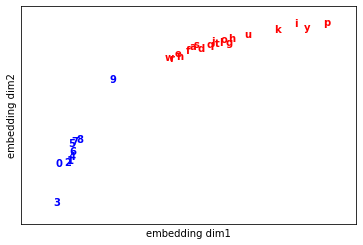

In [3]:
import tensorflow as tf
from tensorflow import keras
from utils import process_w2v_data     
from visual import show_w2v_word_embedding  

corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]


class SkipGram(keras.Model):
    def __init__(self, v_dim, emb_dim):
        super().__init__()
        self.v_dim = v_dim   # 幾個不同的英文單字
         # output_dim=emb_dim is 隱藏層數量
        self.embeddings = keras.layers.Embedding(     # layer 第一層 is  Embedding
            input_dim=v_dim, output_dim=emb_dim,       # [n_vocab, emb_dim]   
            embeddings_initializer=keras.initializers.RandomNormal(0., 0.1),
        )

        # noise-contrastive estimation
        self.nce_w = self.add_weight(
            name="nce_w", shape=[v_dim, emb_dim],
            initializer=keras.initializers.TruncatedNormal(0., 0.1))  # [n_vocab, emb_dim]
        self.nce_b = self.add_weight(
            name="nce_b", shape=(v_dim,),
            initializer=keras.initializers.Constant(0.1))  # [n_vocab, ]

        self.opt = keras.optimizers.Adam(0.01)

    def call(self, x, training=None, mask=None):
        # x.shape = [n, ]
        o = self.embeddings(x)      # [n, emb_dim]
        return o

    # negative sampling: take one positive label and num_sampled negative labels to compute the loss
    # in order to reduce the computation of full softmax
    def loss(self, x, y, training=None):
        embedded = self.call(x, training)
        return tf.reduce_mean(
            tf.nn.nce_loss(
                weights=self.nce_w, biases=self.nce_b, labels=tf.expand_dims(y, axis=1),
                inputs=embedded, num_sampled=5, num_classes=self.v_dim))
                # sample softmax : num_sampled=5 取5個不是答案的  
    def step(self, x, y):   # training
        with tf.GradientTape() as tape:
            loss = self.loss(x, y, True)
            grads = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.trainable_variables))
        return loss.numpy()


def train(model, data):
    for t in range(2500):
        bx, by = data.sample(8)
        loss = model.step(bx, by)
        if t % 200 == 0:
            print("step: {} | loss: {}".format(t, loss))


if __name__ == "__main__":
    d = process_w2v_data(corpus, skip_window=2, method="skip_gram")
    print(d.i2v[0])
    print(d.i2v[1])
    print(d.i2v[2])
    
    print(d.v2i['9'])
    print(d.v2i['o'])
    m = SkipGram(d.num_word, 2)
    train(m, d)

    # plotting
    show_w2v_word_embedding(m, d, "./visual/results/skipgram.png")

In [4]:
from __future__ import division, print_function, absolute_import
import collections
import os
import random
import urllib
import zipfile
from urllib.request import urlretrieve
import numpy as np
import tensorflow as tf
tf.compat.v1.reset_default_graph


learning_rate = 0.1
batch_size = 128
num_steps = 10000
display_step = 1000
eval_step = 500


eval_words = ['five', 'of', 'going', 'hardware', 'american', 'britain']


embedding_size = 128 
max_vocabulary_size = 50000 
min_occurrence = 10  
skip_window = 1 
num_skips = 2 
num_sampled = 64 

In [5]:
import urllib.request

url = 'http://mattmahoney.net/dc/text8.zip'
data_path = 'text8.zip'
if not os.path.exists(data_path):
    print("Downloading the dataset... (It may take some time)")
    filename, _ = urllib.request.urlretrieve(url, data_path)
    print("Done!")

with zipfile.ZipFile(data_path) as f:
    text_words = f.read(f.namelist()[0]).decode('utf8').lower().split()

In [6]:
count = [('UNK', -1)]
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))

for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:

        break

vocabulary_size = len(count)

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i

data = list()
unk_count = 0
for word in text_words:
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)
id2word = dict(zip(word2id.values(), word2id.keys()))

print("Words count:", len(text_words))       # text8 有多少英文單字
print("Unique words:", len(set(text_words))) # test8 有多少不同的單字
print("Vocabulary size:", vocabulary_size)   # 剔除小於10次出現的字
print("Most common words:", count[:10])

print(id2word[10])
print(word2id['apple'])

Words count: 17005207
Unique words: 253854
Vocabulary size: 47135
Most common words: [('UNK', 444176), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
two
1221


In [7]:
data_index = 0

def next_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [8]:

with tf.device('/cpu:0'):

    embedding = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))

    nce_weights = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

def get_embedding(x):
    with tf.device('/cpu:0'):

        x_embed = tf.nn.embedding_lookup(embedding, x)
        return x_embed

def nce_loss(x_embed, y):
    with tf.device('/cpu:0'):

        y = tf.cast(y, tf.int64)
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                           biases=nce_biases,
                           labels=y,
                           inputs=x_embed,
                           num_sampled=num_sampled,
                           num_classes=vocabulary_size))
        return loss

# 评估
def evaluate(x_embed):
    with tf.device('/cpu:0'):

        x_embed = tf.cast(x_embed, tf.float32)
        x_embed_norm = x_embed / tf.sqrt(tf.reduce_sum(tf.square(x_embed)))
        embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True), tf.float32)
        cosine_sim_op = tf.matmul(x_embed_norm, embedding_norm, transpose_b=True)
        return cosine_sim_op


optimizer = tf.optimizers.SGD(learning_rate)

In [17]:
def run_optimization(x, y):
    with tf.device('/cpu:0'):

        with tf.GradientTape() as g:
            emb = get_embedding(x)
            loss = nce_loss(emb, y)

        gradients = g.gradient(loss, [embedding, nce_weights, nce_biases])

        optimizer.apply_gradients(zip(gradients, [embedding, nce_weights, nce_biases]))

In [18]:

# print(word2id)
x_test = np.array([word2id[str(w)] for w in eval_words])

for step in range(1, num_steps + 1):
    batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
    run_optimization(batch_x, batch_y)

    if step % display_step == 0 or step == 1:
        loss = nce_loss(get_embedding(batch_x), batch_y)
        print("step: %i, loss: %f" % (step, loss))

    if step % eval_step == 0 or step == 1:
        print("Evaluation...")
        sim = evaluate(get_embedding(x_test)).numpy()
        for i in range(len(eval_words)):
            top_k = 8 
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = '"%s" nearest neighbors:' % eval_words[i]
            for k in range(top_k):
                log_str = '%s %s,' % (log_str, id2word[nearest[k]])
            print(log_str)

step: 1, loss: 462.917206
Evaluation...
"five" nearest neighbors: elsa, intuitively, phoebe, turret, dialysis, conflicted, surveyor, szko,
"of" nearest neighbors: algebraic, haworth, shawnee, wisconsin, goodall, homophobic, concur, cobbler,
"going" nearest neighbors: rembrandt, faraway, ayrton, osh, unmarked, decimus, longing, clearwater,
"hardware" nearest neighbors: multihull, refused, archiepiscopal, roslin, franciscan, invaders, undertaken, dealerships,
"american" nearest neighbors: brava, favoring, starship, wittgenstein, conglomerate, sided, raps, awry,
"britain" nearest neighbors: virginal, hus, transboundary, caracalla, musings, gravis, deneb, emphasis,
Evaluation...
"five" nearest neighbors: two, three, four, six, eight, zero, by, one,
"of" nearest neighbors: the, and, in, to, a, that, it, is,
"going" nearest neighbors: longing, ayrton, concerti, hidden, osh, rembrandt, decimus, ectopic,
"hardware" nearest neighbors: refused, multihull, archiepiscopal, undertaken, franciscan, 

Evaluation...
"five" nearest neighbors: four, six, three, seven, two, eight, one, zero,
"of" nearest neighbors: and, in, by, at, but, for, this, on,
"going" nearest neighbors: western, found, name, march, books, use, large, book,
"hardware" nearest neighbors: part, trade, man, several, you, son, control, forces,
"american" nearest neighbors: by, that, at, in, were, and, when, this,
"britain" nearest neighbors: became, called, members, out, come, german, work, university,
step: 90000, loss: 54.702293
Evaluation...
"five" nearest neighbors: four, six, three, seven, eight, two, one, zero,
"of" nearest neighbors: in, and, on, or, for, by, its, but,
"going" nearest neighbors: western, found, name, march, books, use, large, used,
"hardware" nearest neighbors: part, trade, man, several, you, son, forces, control,
"american" nearest neighbors: by, some, were, which, from, or, who, for,
"britain" nearest neighbors: became, called, members, come, out, german, university, thought,
Evaluation...
"

C:\Users\mikal\Envs\mika2022_tf2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mikal\Envs\mika2022_tf2\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


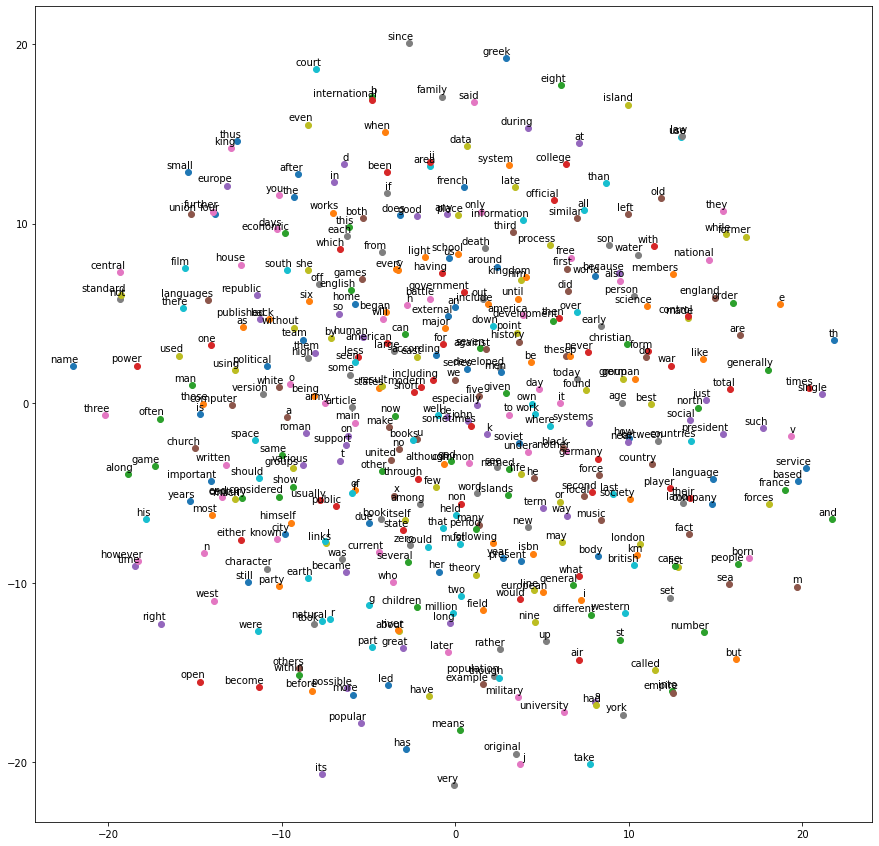

In [9]:
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embedding[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                        ha='right', va='bottom')
    pylab.show()

words = [id2word[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)